# Block vs non-block, normalisation vs non-normalisation - One Dimensional analysis, using user RL code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dwidth = 512

In [3]:
#noiselevel = 0.002
noiselevel = 0.005

In [4]:
#Create data

x= np.arange(dwidth,dtype=np.float32)
data=np.zeros_like(x)

#circular bumps
#bumps (pos, radius)
xbumps = [ (150,20) , (200,10), (300,30), (315,10)]

for xpos,r in xbumps:
    data+= np.sqrt( np.where( np.abs(x-xpos) < r, 1, 0) * (r**2 - (x-xpos)**2 ) )/r

#rectangular bumps
#(xstart, xend, height)
xrectbumps = [ (110,115), (250,252) , (350,400)]
for x0, x1 in xrectbumps:
    data+= np.where( x<x1, 1,0)* np.where(x>=x0,1,0)

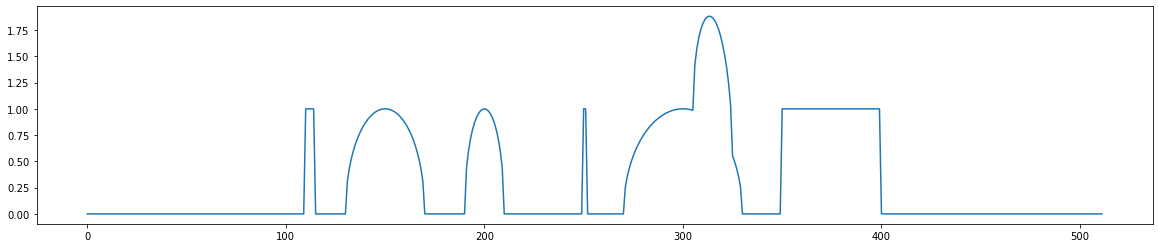

In [5]:
plt.figure(figsize=(20,4))
plt.plot(x,data)

## PSF

In [6]:
#convolute with a 3D gaussian centered at (0,0,0)
w_psf = 16
w_psf_half = int(w_psf/2)

x_psf = np.linspace(-w_psf_half, + w_psf_half,w_psf)
gauss1d = np.exp( np.multiply(x_psf,x_psf)/ -8 )

In [7]:
x_psf.shape

(16,)

In [8]:
# Normalise to sum
psf_norm = gauss1d / gauss1d.sum()

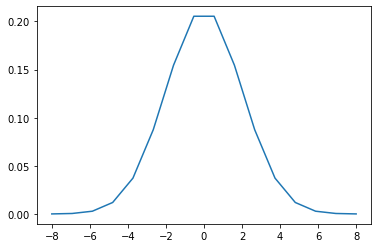

In [9]:
plt.plot(x_psf,psf_norm)

In [10]:
#Circulify psf
psf_norm0 = np.roll(psf_norm, int(psf_norm.shape[0]/2) )

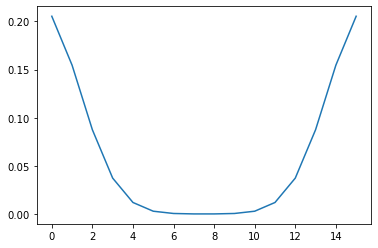

In [11]:
plt.plot(psf_norm0)

Convolve data

In [12]:
from scipy import signal
#Convolute data with gaussian
data_psfconv = signal.convolve(data, psf_norm , mode = 'full') # I believe that this already takes into account that psf is not centered
#data_psfconv = signal.convolve(data, psf_norm0 , mode = 'full') # Gives strange results

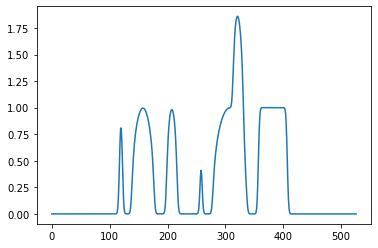

In [13]:
plt.plot(data_psfconv) #note that the result shifted

In [14]:
data_psfconv.shape

(527,)

In [15]:
# Add noise
#Use poisson noise
#https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
from numpy.random import default_rng
rng = default_rng()

noise3d = rng.poisson(lam=25, size=data_psfconv.shape)

data3dconvnoise = data_psfconv + noise3d*data_psfconv.max()*noiselevel

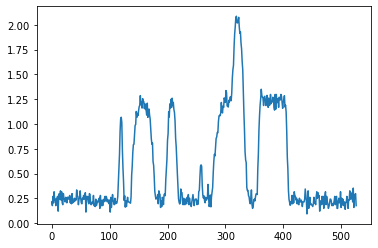

In [16]:
plt.plot(data3dconvnoise)

In [17]:
data3dconvnoise.shape

(527,)

Create a cropped region

In [18]:
x_crop_0, x_crop_1 = 100 , 350
data_crop = data3dconvnoise[x_crop_0:x_crop_1]

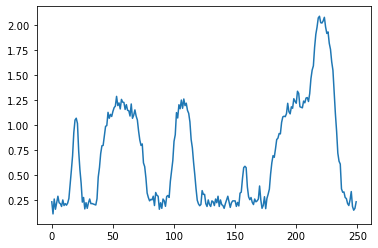

In [19]:
plt.plot(data_crop)

## RL deconvolution, user code

In [20]:
def RL0(data, psf, niter, do_edge_norm=True):
    #print("data.shape :",data.shape)
    #print("psf shape :", psf.shape)
    #Uses normalisation of data for extended size

    #Check data is one dim
    if data.ndim!= 1 and psf.ndim!=1:
        print ("Error: data and/or psf are not 1D. Returning None")
        return None
    
    # #Make sure data shape is even by cropping extra if needed
    # if data.shape[0] % 2 != 0 :
    #     data = data[:-1]
    #     print("new data.shape :",data.shape)

    #make sure psf is normalised sum
    psf0 = psf/ psf.sum()

    #Create a psf-like array that will be used to resize data
    delta_arr = np.zeros_like(psf0)
    phw = int(psf0.shape[0]/2) #Half-width of the psf
    delta_arr[ phw ] = 1.0
    data_shaped = np.convolve(data, delta_arr, mode='full')
    #print("data_shaped shape:", data_shaped.shape)

    onesarray = np.ones_like(data)
    normarray = np.convolve(onesarray, psf0,mode='full')

    psf0_flip = np.flip(psf0)

    xn1 = np.array(data) #Initialise copy

    for i in range(niter):
        #print("iteration: ", i)
        xn=xn1
        #Convolution at denominator
        u0 = np.convolve(xn, psf0, mode='full')
        #print("u0 shape:", u0.shape)

        #TODO: May need to fix values that are too close to zero

        #Division
        div0 = data_shaped / u0 #TODO: check sizes are compatible

        #Convolve the result with flipped psf
        u2 = np.convolve(div0,psf0_flip, mode='same') #Use same setting to crop result
        #print("u2 shape:", u2.shape)

        #Multiplication with previous estimation
        #mult0 = np.multiply(xn, u2) #Error in sizes, should use extended previous estimation
        xn_ext = np.convolve(xn, delta_arr, mode='full')
        #print("xn_ext shape:", xn_ext.shape)

        mult0 = np.multiply(xn_ext,u2)

        norm0 = None
        #Optionally divide with normalisation array
        if do_edge_norm==True:
            norm0 = np.divide(mult0, normarray)
        else:
            norm0= mult0

        #crop result
        xn1 = norm0[phw:-phw+1]
        #print("xn1 shape:", xn1.shape)

    res = xn1

    return res

In [21]:
niter=21

In [22]:
deconv_RL0 = RL0(data3dconvnoise,psf_norm, niter)

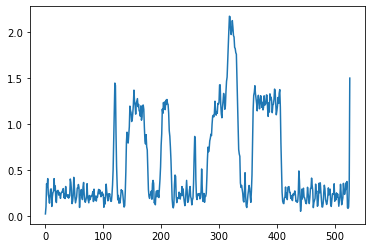

In [23]:
plt.plot(deconv_RL0)

Calculate RL in cropped section of data

In [24]:
deconv_RL0_crop = RL0(data_crop,psf_norm, niter)

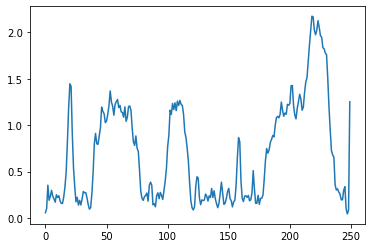

In [25]:
plt.plot(deconv_RL0_crop)

Compare results

In [26]:
deconv_RL0.shape

(527,)

In [27]:
deconv_RL0[x_crop_0:x_crop_1].shape

(250,)

In [28]:
deconv_RL0_crop.shape

(250,)

In [29]:
diffsq = np.power(deconv_RL0_crop-deconv_RL0[x_crop_0:x_crop_1], 2)

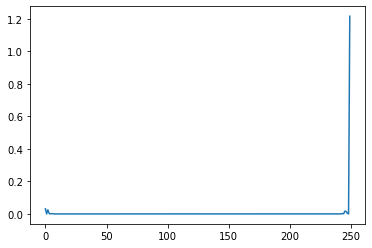

In [30]:
plt.plot(diffsq)

In [31]:
diffsq_valid = diffsq < 1e-12

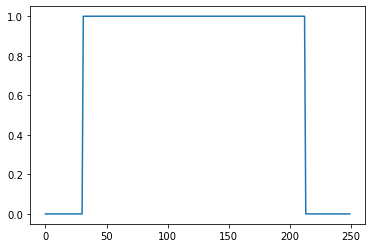

In [32]:
plt.plot(diffsq_valid)

In [33]:
#Get maximum width
def get_max_width(data1d, valcond = 1):
    maxwidth0=0
    width0=0
    for i in range(data1d.shape[0]):
        v0 = data1d[i]
        if v0==valcond:
            width0+=1
        else:
            width0==0
        maxwidth0 = max(maxwidth0,width0)
    return maxwidth0

In [34]:
get_max_width(diffsq_valid)

182

That's a significantly improved value

For this RL calculation and croping , try to get max_width of the valid cropped region as a function of number of iterations used in RL

In [35]:
def crop_vs_noncrop_RL_diff_get_valid_max_width(niter0=20):
    #print( data3dconvnoise.shape)
    deconv_skimageRL = RL0(data3dconvnoise,psf_norm, niter0)
    deconv_skimageRL_crop = RL0(data_crop,psf_norm, niter0)
    diffsq = np.power(deconv_skimageRL_crop-deconv_skimageRL[x_crop_0:x_crop_1 ], 2)
    diffsq_valid0 = diffsq < 1e-12
    m0 = get_max_width(diffsq_valid0)
    return m0

In [36]:
#test
crop_vs_noncrop_RL_diff_get_valid_max_width(19)

181

In [59]:
niter_range = np.arange(2,100)
maxwidths_vs_niter = []
for niter0 in niter_range:
    maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width(niter0)
    print("niter0: ", niter0 , ", maxwidth:", maxwidth)
    maxwidths_vs_niter.append( (niter0,maxwidth) )

niter0:  2 , maxwidth: 215
niter0:  3 , maxwidth: 207
niter0:  4 , maxwidth: 202
niter0:  5 , maxwidth: 200
niter0:  6 , maxwidth: 195
niter0:  7 , maxwidth: 198
niter0:  8 , maxwidth: 195
niter0:  9 , maxwidth: 192
niter0:  10 , maxwidth: 193
niter0:  11 , maxwidth: 192
niter0:  12 , maxwidth: 191
niter0:  13 , maxwidth: 190
niter0:  14 , maxwidth: 187
niter0:  15 , maxwidth: 188
niter0:  16 , maxwidth: 185
niter0:  17 , maxwidth: 185
niter0:  18 , maxwidth: 183
niter0:  19 , maxwidth: 181
niter0:  20 , maxwidth: 183
niter0:  21 , maxwidth: 182
niter0:  22 , maxwidth: 180
niter0:  23 , maxwidth: 181
niter0:  24 , maxwidth: 178
niter0:  25 , maxwidth: 178
niter0:  26 , maxwidth: 179
niter0:  27 , maxwidth: 179
niter0:  28 , maxwidth: 179
niter0:  29 , maxwidth: 179
niter0:  30 , maxwidth: 180
niter0:  31 , maxwidth: 177
niter0:  32 , maxwidth: 175
niter0:  33 , maxwidth: 174
niter0:  34 , maxwidth: 177
niter0:  35 , maxwidth: 177
niter0:  36 , maxwidth: 175
niter0:  37 , maxwidth: 175


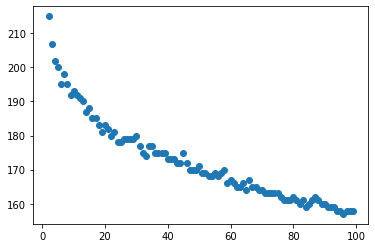

In [60]:
plt.scatter(*zip(*maxwidths_vs_niter))

Plot shows that valid region in a cropped block after the RL deconvolution drops with the number of RL iterations in an exponential way.

When doing block deconvolution, this may need to be taken into account.

It remains to see how the psf size also affects the padding region needed to be considered

Try to fit an exponential or 1/x ?

In [61]:
maxwidths_np = np.array(maxwidths_vs_niter)
maxwidths_np

array([[  2, 215],
       [  3, 207],
       [  4, 202],
       [  5, 200],
       [  6, 195],
       [  7, 198],
       [  8, 195],
       [  9, 192],
       [ 10, 193],
       [ 11, 192],
       [ 12, 191],
       [ 13, 190],
       [ 14, 187],
       [ 15, 188],
       [ 16, 185],
       [ 17, 185],
       [ 18, 183],
       [ 19, 181],
       [ 20, 183],
       [ 21, 182],
       [ 22, 180],
       [ 23, 181],
       [ 24, 178],
       [ 25, 178],
       [ 26, 179],
       [ 27, 179],
       [ 28, 179],
       [ 29, 179],
       [ 30, 180],
       [ 31, 177],
       [ 32, 175],
       [ 33, 174],
       [ 34, 177],
       [ 35, 177],
       [ 36, 175],
       [ 37, 175],
       [ 38, 175],
       [ 39, 175],
       [ 40, 173],
       [ 41, 173],
       [ 42, 173],
       [ 43, 172],
       [ 44, 172],
       [ 45, 175],
       [ 46, 172],
       [ 47, 170],
       [ 48, 170],
       [ 49, 170],
       [ 50, 171],
       [ 51, 169],
       [ 52, 169],
       [ 53, 168],
       [ 54,

In [81]:
from scipy.optimize import curve_fit

def exp_func(x,a,b,c):
    return a*np.exp(b*x)+c

def over_x_func(x,a,c):
    return a / x +c

exp_fit_res = curve_fit(exp_func,maxwidths_np[:,0], maxwidths_np[:,1], p0=(200,-1,100))

overx_fit_res = curve_fit(over_x_func,maxwidths_np[:,0], maxwidths_np[:,1] , p0=(1,150))

In [82]:
exp_fit_res

(array([ 4.96140521e+01, -2.81740138e-02,  1.56445590e+02]),
 array([[ 7.91820075e-01,  1.99374068e-04, -3.55255963e-01],
        [ 1.99374068e-04,  2.72800814e-06, -1.40217097e-03],
        [-3.55255963e-01, -1.40217097e-03,  8.49509415e-01]]))

In [83]:
overx_fit_res

(array([146.62629703, 166.33149595]),
 array([[115.7144137 ,  -4.93247742],
        [ -4.93247742,   0.74964509]]))

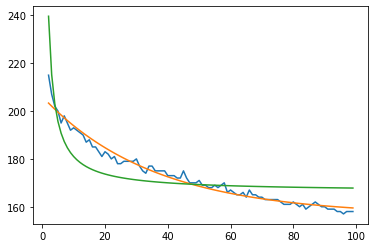

In [84]:
plt.plot( maxwidths_np[:,0], maxwidths_np[:,1])
plt.plot(maxwidths_np[:,0], exp_func(maxwidths_np[:,0], *exp_fit_res[0]))
plt.plot(maxwidths_np[:,0], over_x_func(maxwidths_np[:,0], *overx_fit_res[0]))

Exponential fits better with data

## Get maxwidth as a function of number of iterations and psf size

In [39]:
def crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(niter0=20, psf_half_width0=8):
    #print(niter, psf_half_width0)
    #print(data.shape)

    #convolute with a 3D gaussian centered at (0,0,0)
    psf_width0 = 2*psf_half_width0

    x_psf0 = np.linspace(-psf_half_width0, + psf_half_width0,psf_width0)
    gauss1d0 = np.exp( -np.multiply(x_psf0,x_psf0) / psf_half_width0 )
    psf_norm0 = gauss1d0 / gauss1d0.sum()

    data_psfconv0 = signal.convolve(data, psf_norm0 , mode = 'full') # I believe that this already takes into account that psf is not centered
    
    #Add noise
    rng = default_rng()
    noise3d = rng.poisson(lam=25, size=data_psfconv0.shape)
    data3dconvnoise0 = data_psfconv0 + noise3d*data_psfconv0.max()*0.002

    x_crop_0, x_crop_1 = 100 , 350
    data_crop0 = data3dconvnoise0[x_crop_0:x_crop_1]

    deconv_skimageRL0 = RL0(data3dconvnoise0,psf_norm0, niter0)
    deconv_skimageRL_crop0 = RL0(data_crop0,psf_norm0, niter0)

    diffsq0 = np.power( deconv_skimageRL_crop0 - deconv_skimageRL0[x_crop_0:x_crop_1 ], 2)
    diffsq_valid0 = diffsq0 < 1e-12
    m0 = get_max_width(diffsq_valid0)
    return m0

In [40]:
#test
crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize()

186

In [47]:
niter_range = np.arange(2,100)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth = []
for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(niter0, phw0)
        print("niter0: ", niter0 , ", psf_width:", phw0 , ", maxwidth:", maxwidth)
        maxwidths_vs_niter_and_psfhwidth.append( (niter0,phw0,maxwidth) )

niter0:  2 , psf_width: 8 , maxwidth: 216
niter0:  2 , psf_width: 9 , maxwidth: 214
niter0:  2 , psf_width: 10 , maxwidth: 211
niter0:  2 , psf_width: 11 , maxwidth: 210
niter0:  2 , psf_width: 12 , maxwidth: 207
niter0:  2 , psf_width: 13 , maxwidth: 206
niter0:  2 , psf_width: 14 , maxwidth: 204
niter0:  2 , psf_width: 15 , maxwidth: 202
niter0:  2 , psf_width: 16 , maxwidth: 200
niter0:  2 , psf_width: 17 , maxwidth: 199
niter0:  2 , psf_width: 18 , maxwidth: 198
niter0:  2 , psf_width: 19 , maxwidth: 196
niter0:  2 , psf_width: 20 , maxwidth: 194
niter0:  2 , psf_width: 21 , maxwidth: 192
niter0:  2 , psf_width: 22 , maxwidth: 191
niter0:  2 , psf_width: 23 , maxwidth: 190
niter0:  2 , psf_width: 24 , maxwidth: 188
niter0:  2 , psf_width: 25 , maxwidth: 187
niter0:  2 , psf_width: 26 , maxwidth: 187
niter0:  2 , psf_width: 27 , maxwidth: 185
niter0:  2 , psf_width: 28 , maxwidth: 184
niter0:  2 , psf_width: 29 , maxwidth: 182
niter0:  2 , psf_width: 30 , maxwidth: 181
niter0:  2 , 

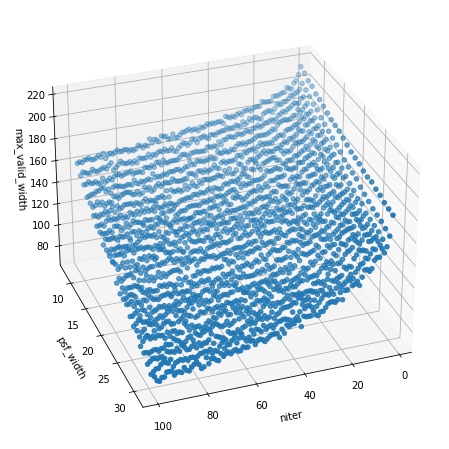

In [50]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', )
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth))
ax.set_xlabel('niter')
ax.set_zlabel('max_valid_width')
ax.set_ylabel('psf_width')
ax.view_init(azim=70)
plt.show()

Increasing PSF width makes valid_width reduce significantly in an apparent linear fashion

In [43]:
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_psfwidth = []
niter0=20 #Fixed number of RL iterations

for phw0 in psf_hwidth_range:
    maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(niter0, phw0)
    print("psf_width: ", phw0 , ", maxwidth:", maxwidth, )
    maxwidths_vs_psfwidth.append( (phw0,maxwidth) )

psf_width:  8 , maxwidth: 186
psf_width:  9 , maxwidth: 185
psf_width:  10 , maxwidth: 178
psf_width:  11 , maxwidth: 178
psf_width:  12 , maxwidth: 173
psf_width:  13 , maxwidth: 167
psf_width:  14 , maxwidth: 167
psf_width:  15 , maxwidth: 162
psf_width:  16 , maxwidth: 162
psf_width:  17 , maxwidth: 159
psf_width:  18 , maxwidth: 156
psf_width:  19 , maxwidth: 153
psf_width:  20 , maxwidth: 148
psf_width:  21 , maxwidth: 146
psf_width:  22 , maxwidth: 147
psf_width:  23 , maxwidth: 141
psf_width:  24 , maxwidth: 140
psf_width:  25 , maxwidth: 139
psf_width:  26 , maxwidth: 133
psf_width:  27 , maxwidth: 131
psf_width:  28 , maxwidth: 128
psf_width:  29 , maxwidth: 119
psf_width:  30 , maxwidth: 123
psf_width:  31 , maxwidth: 122


Text(0, 0.5, 'max valid width')

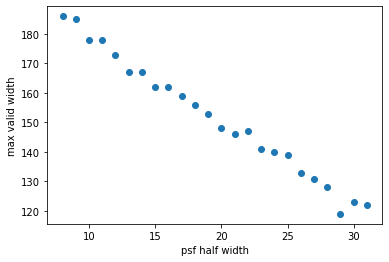

In [44]:
plt.scatter(*zip(*maxwidths_vs_psfwidth))
#plt.axline(*zip(*maxwidths_vs_psfwidth))
plt.xlabel("psf half width")
plt.ylabel("max valid width")

Confirmation that maximum valid width decreases linearly as the psf size increases.

Try to fit a line and get the parameters

In [45]:
maxwidths_vs_psfwidth_np = np.array(maxwidths_vs_psfwidth)
maxwidths = maxwidths_vs_psfwidth_np[:,1]
psfhwidth = maxwidths_vs_psfwidth_np[:,0]

In [46]:
fitparams = np.polyfit(maxwidths, 2*psfhwidth, 1)
fitparams

array([ -0.69309849, 144.20657467])

Interesting, the maxwidth does not reduce by a -1.0*psfwidth .

Try to fit max_width vs niter and psfwidth with a formula

Maybe something like

max_width = -k*phw 